In [1]:
import Pkg
Pkg.activate(".")
#Pkg.instantiate()

Activating environment at `~/projects/LeNet.jl/Project.toml`


In [2]:
using Images
using Knet

if Knet.gpu() >= 0
    ATYPE = KnetArray{Float32}
    to_nn = gpucopy
else
    ATYPE = Array{Float32}
    to_nn = identity
end
ATYPE

KnetArray{Float32,N} where N

In [3]:
using LeNet.MNIST

train_images, train_labels, _ = train_dataset()
test_images, test_labels, _ = test_dataset()

@show typeof(train_images)
@show size(train_images)
@show typeof(train_labels)
@show size(train_labels)

# prepare testing batches
train_data_chk = minibatch(train_images, train_labels, 5000; xtype=ATYPE);
test_data_chk = minibatch(test_images, test_labels, 5000; xtype=ATYPE);

typeof(train_images) = PaddedViews.PaddedView{Normed{UInt8,8},3,Tuple{Base.OneTo{Int64},Base.OneTo{Int64},Base.OneTo{Int64}},OffsetArrays.OffsetArray{Normed{UInt8,8},3,Array{Normed{UInt8,8},3}}}
size(train_images) = (32, 32, 60000)
typeof(train_labels) = Array{Int64,1}
size(train_labels) = (60000,)


In [4]:
using LeNet, Printf

model = load_model(LeNet5, "LeNet5-model.jld2")

@printf "accuracy(train_data) = %f %%\n" (accuracy(model, train_data_chk)*100)
@printf "accuracy(test_data) = %f %%\n" (accuracy(model, test_data_chk)*100)

accuracy(train_data) = 98.766667 %
accuracy(test_data) = 98.270000 %


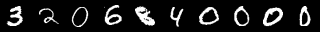

"3, 2, 0, 6, 8, 4, 0, 0, 0, 0"

In [5]:
n = size(test_images)[end]
idx = rand(1:n, 10)

hcat([test_images[:,:,i] .|> Gray for i in idx]...) |> display

join([string(model(test_images[:,:,i:i] .|> Float32 |> to_nn) |> argmax |> x -> x[1]%10) for i in idx], ", ")

In [1]:
using JLD2, FileIO

path = "LeNet5-training.jld2"
acc_train, acc_test = jldopen(path, "r") do file
    acc_train = file["lenet5/training/acc_train"]
    acc_test = file["lenet5/training/acc_test"]
    (acc_train, acc_test)
end

([0.11073333333333334, 0.37385, 0.5583833333333333, 0.5850666666666666, 0.6811333333333334, 0.7490833333333333, 0.79795, 0.82615, 0.8443166666666667, 0.8565  …  0.98205, 0.9821166666666666, 0.98215, 0.9821833333333333, 0.9822333333333333, 0.9823333333333333, 0.9823833333333334, 0.9824333333333334, 0.9825166666666667, 0.9825666666666667], [0.1112, 0.3806, 0.5739, 0.5998, 0.6987, 0.7602, 0.8106, 0.8377, 0.8549, 0.8634  …  0.9799, 0.9799, 0.9799, 0.9799, 0.98, 0.9801, 0.9802, 0.9804, 0.9804, 0.9806])

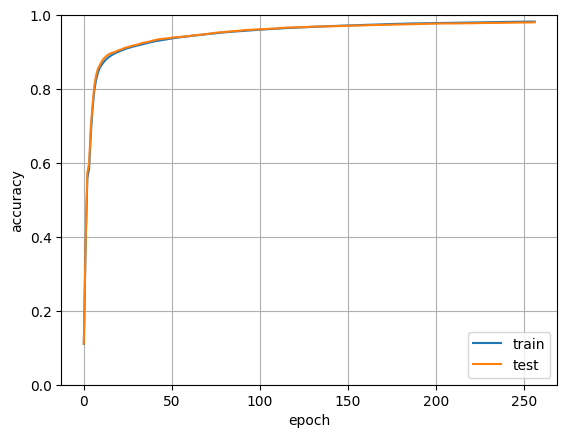

(0.0, 1.0)

In [7]:
using PyPlot

plot(acc_train, label="train")
plot(acc_test, label="test")
grid(true)
legend()
xlabel("epoch")
ylabel("accuracy")
ylim(0.0, 1.0)